In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = 'data/'

data = pd.read_csv(DATA_PATH + 'p2-arbres-fr.csv', sep=';')

# Nettoyage des données

## Quelle variable pour l'espèce d'arbre ?

In [37]:
genre_na = data.genre.isna().sum()
genre_unique = data.genre.unique().shape

espece_na = data.variete.isna().sum()
espece_unique = data.variete.unique().shape

variete_na = data.variete.isna().sum()
variete_unique = data.variete.unique().shape

(176,)

## Valeurs aberrantes 

### Hauteur

In [39]:
data.remarquable.unique()

array([ 0., nan,  1.])

### Circonférence

In [40]:
data.isna().mean()

id                     0.000000
type_emplacement       0.000000
domanialite            0.000005
arrondissement         0.000000
complement_addresse    0.845596
numero                 1.000000
lieu                   0.000000
id_emplacement         0.000000
libelle_francais       0.007480
genre                  0.000080
espece                 0.008754
variete                0.816241
circonference_cm       0.000000
hauteur_m              0.000000
stade_developpement    0.335795
remarquable            0.315274
geo_point_2d_a         0.000000
geo_point_2d_b         0.000000
dtype: float64

In [22]:
# Variables redondantes et presque vides
# On garde genre plutot que libelle car il y a plus de données et moins de modalités

var_inutiles = ['lieu', 'id_emplacement', 'type_emplacement']
var_vides = ['complement_addresse', 'numero', 'espece', 'variete', 'libelle_francais']
var_drop = var_inutiles + var_vides

df = data.drop(var_drop, axis=1)
# Formattage de la colonne remarquable
df['remarquable'] = df.remarquable.isna()


# Extraction des données pour l'analyse

In [3]:
# Extraction de datasets
from sklearn.preprocessing import OneHotEncoder

# Coordonnées 
data_geo = df[['geo_point_2d_a', 'geo_point_2d_b']]

# Dominalité
dom_list = ['Alignement', 'Jardin', 'CIMETIERE']

temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
temp = temp[temp.domanialite.isin(dom_list)]

new_name = {0: 'Alignement',
         1: 'CIMETIERE', 
         2: 'Jardin'}

dom = temp[['circonference_cm', 'hauteur_m', 'domanialite']].dropna()
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_dom = pd.DataFrame(encoder.fit_transform(dom[['domanialite']]).toarray())
final_dom = dom.join(encoder_dom)
final_dom.rename(columns = new_name, inplace = True)

# Age de l'arbre
temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
dev = temp[['circonference_cm', 'hauteur_m', 'stade_developpement']].dropna()

dev['A'] = dev['stade_developpement'] == 'A'
dev['J'] = dev['stade_developpement'] == 'J'
dev['M'] = dev['stade_developpement'] == 'M'
dev['JA'] = dev['stade_developpement'] == 'JA'

# Repartition en fonction de la domanialité

align = df[df['domanialite'] == 'Alignement']
jardin = df[df['domanialite'] == 'Jardin']
cimetiere = df[df['domanialite'] == 'CIMETIERE']

# Domanialité vs stade de développement

temp = df[df['circonference_cm'] < 600]
temp = temp[temp['hauteur_m'] < 200]
full = temp[['stade_developpement', 'domanialite']].dropna()

full['A'] = full['stade_developpement'] == 'A'
full['J'] = full['stade_developpement'] == 'J'
full['M'] = full['stade_developpement'] == 'M'
full['JA'] = full['stade_developpement'] == 'JA'
full['Alignement'] = full['domanialite'] == 'Alignement'
full['Cimetière'] = full['domanialite'] == 'CIMETIERE'
full['Jardin'] = full['domanialite'] == 'Jardin'

In [41]:
full

,stade_developpement,domanialite,A,J,M,JA,Alignement,Cimetière,Jardin
1,A,Jardin,True,False,False,False,False,False,True
2,A,Jardin,True,False,False,False,False,False,True
3,A,Jardin,True,False,False,False,False,False,True
8,A,Jardin,True,False,False,False,False,False,True
9,A,Jardin,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
198859,J,DJS,False,True,False,False,False,False,False
198860,J,Jardin,False,True,False,False,False,False,True
198861,JA,Jardin,False,False,False,True,False,False,True
198862,JA,Jardin,False,False,False,True,False,False,True


# Data explo

## Domanialite

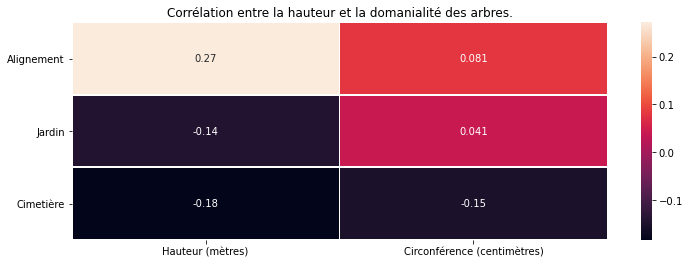

In [26]:
cr = final_dom.corr()
final_cr = cr.loc[['Alignement', 'Jardin', 'CIMETIERE'], ['hauteur_m', 'circonference_cm']]
plot = sns.heatmap(final_cr, annot=True, linewidths=.7)
plot.set_xticklabels(['Hauteur (mètres)', 'Circonférence (centimètres)'])
plot.set_yticklabels(['Alignement', 'Jardin', 'Cimetière'])
plot.set_title('Corrélation entre la hauteur/circonférence et la domanialité des arbres.')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Domanialité_taille_corr.png')

Correlation plus difficile à trouver avec la circonference qu'avec la hauteur.
Il ya un vrai lien entre l'usage de l'arbre et ses caractéristiques.

## Stade de développement

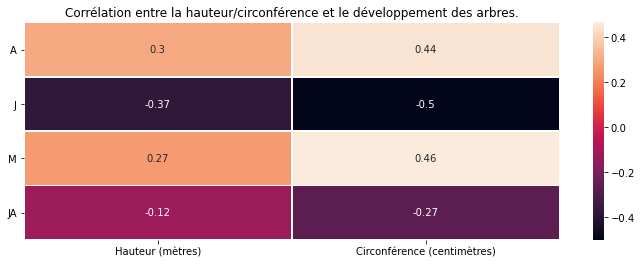

In [28]:
cr = dev.corr()
final_cr = cr.loc[['A', 'J', 'M', 'JA'], ['hauteur_m', 'circonference_cm']]
plot = sns.heatmap(final_cr, annot=True, linewidths=.7)
plot.set_title('Corrélation entre la hauteur/circonférence et le développement des arbres.')
plot.set_xticklabels(['Hauteur (mètres)', 'Circonférence (centimètres)'])

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Développement_taille_corr.png')

J > JA > M > A

## Stade de développement vs domanialité

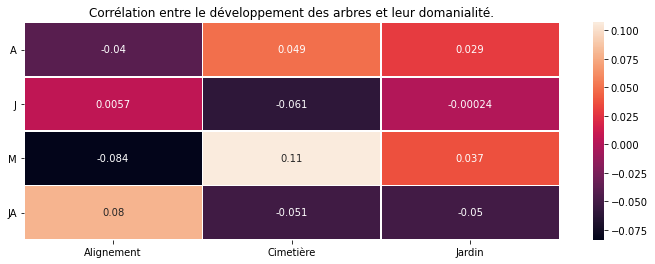

In [29]:
cr = full.corr().loc[['A', 'J', 'M', 'JA'], ['Alignement', 'Cimetière', 'Jardin']]

plot = sns.heatmap(cr, annot=True, linewidths=.7)
plot.set_title('Corrélation entre le développement des arbres et leur domanialité.')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.yticks(rotation=0)
plt.savefig('graphs/Développement_domanialité_corr.png')

## Domanialité vs espèces

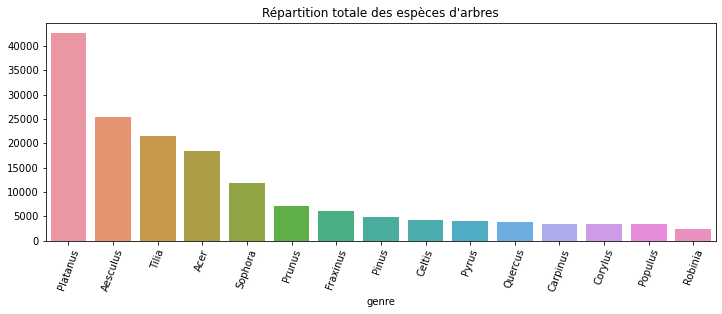

In [21]:
# Repartition totale des espèces

temp = df.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
most_trees = temp.index.to_list()
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition totale des espèces d'arbres")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/genre_répartition.png')

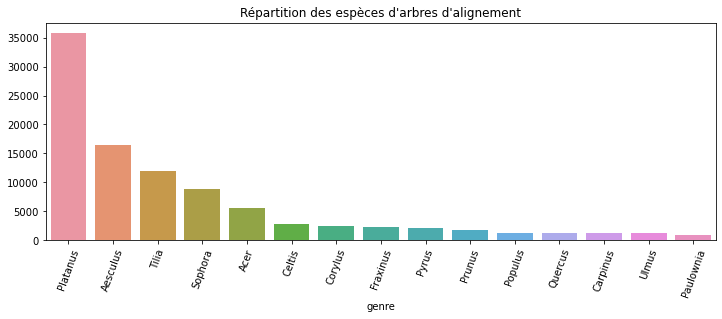

In [20]:
# Répartition des alignements

temp = align.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition des espèces d'arbres d'alignement")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/alignement_genre_répartition.png')

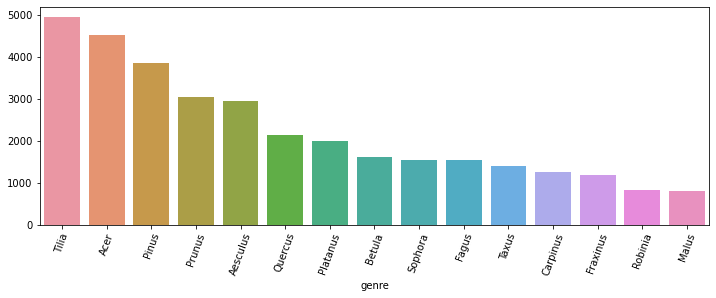

In [18]:
# Répartition des jardins

temp = jardin.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set(title="Répartition des espèces d'arbres de jardin")

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/jardin_genre_répartition.png')

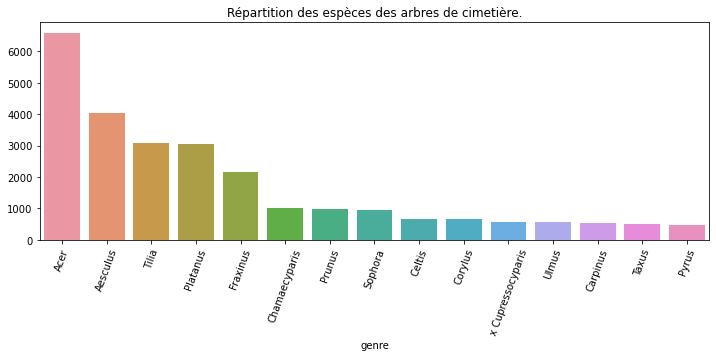

In [30]:
# Répartition des cimetières

temp = cimetiere.groupby(by = 'genre').count()['id'].sort_values(ascending = False)[:15]
plot = sns.barplot(x = temp.index, y = temp.values)
plot.set_title('Répartition des espèces des arbres de cimetière.')

plt.xticks(rotation=70)
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.savefig('graphs/cimetière_genre_répartition.png')